In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- USER EDIT: set these two paths ---
CSV_PATH = "/sdf/data/rubin/user/mrakovci/Projects/Asteroid_detection_CNN/Notebooks/SNR_tests/test.csv"  # your injection catalog
REPO_ROOT = "/sdf/data/rubin/user/mrakovci/Projects/Asteroid_detection_CNN/"  # e.g. "/sdf/home/m/mrakovci/rubin-user/Projects/Asteroid_detection_CNN/ADCNN/data/dataset_creation"
# If you run the notebook from the repo already, leave REPO_ROOT=None.

# Add repo to sys.path so we can import your common.py
if REPO_ROOT is not None:
    rr = Path(REPO_ROOT).resolve()
    if str(rr) not in sys.path:
        sys.path.insert(0, str(rr))

sys.path.insert(0, "/sdf/data/rubin/user/mrakovci/Projects/Asteroid_detection_CNN/ADCNN/data/dataset_creation")
# Import your estimators from common.py (the functions you added)
from ADCNN.data.dataset_creation.simulate_inject import *

# LSST imports (must be in an environment where lsst_distrib is set up)
import lsst.daf.butler as dafButler
import lsst.geom as geom


In [16]:
import concurrent.futures
import pandas as pd
import numpy as np
from lsst.daf.butler import Butler

def worker_df(args):
    """
    Runs one_detector_injection for a single (visit,detector) and returns a pandas DataFrame.
    No H5, no CSV. Only catalog.
    """
    (
        dataId, repo, coll, dims, number, trail_length, magnitude, beta,
        source_type, global_seed, mag_mode, psf_template
    ) = args

    seed = (int(global_seed) * 1_000_003 + int(dataId["visit"]) * 1_003 + int(dataId["detector"])) & 0xFFFFFFFF

    res = one_detector_injection(
        number, trail_length, magnitude, beta,
        repo, coll, dims, source_type, dataId, seed,
        mag_mode=mag_mode, psf_template=psf_template,
        debug=False,
    )

    # res is either (False, dataId, err, tb) or (True, img, mask, real_labels, injection_catalog)
    if res[0] is False:
        _, bad_dataId, err, tb = res
        # Return empty df but keep error info for debugging if you want
        return ("err", bad_dataId, err, tb, None)

    _, img, mask, real_labels, catalog = res
    df = catalog.to_pandas()
    # keep provenance columns
    df["visit"] = int(dataId["visit"])
    df["detector"] = int(dataId["detector"])
    return ("ok", dataId, None, None, df)


def run_parallel_injection_df(
    repo, coll, where,
    number, trail_length, magnitude, beta,
    parallel=4, random_subset=0, train_test_split=0, seed=123, test_only=False,
    bad_visits_file=None, mag_mode="psf_mag", psf_template="image",
):
    """
    Like run_parallel_injection(), but returns one concatenated DataFrame and does not write H5/CSV.
    """
    butler = Butler(repo, collections=coll)

    refs = list(set(
        butler.registry.queryDatasets(
            "preliminary_visit_image",
            where=where,
            instrument="LSSTComCam",
            findFirst=True
        )
    ))
    refs = sorted(refs, key=lambda r: int(r.dataId["visit"]) * 1000 + int(r.dataId["detector"]))

    if bad_visits_file is not None:
        bad_df = pd.read_csv(bad_visits_file)
        bad_set = set(zip(bad_df["visit"].astype(int), bad_df["detector"].astype(int)))
        refs = [r for r in refs if (int(r.dataId["visit"]), int(r.dataId["detector"])) not in bad_set]

    if random_subset > 0:
        rng_subset = np.random.default_rng(seed)
        refs = list(rng_subset.choice(refs, random_subset, replace=False))

    # optional train/test split logic preserved (same as your code)
    rng_split = np.random.default_rng(seed + 1)
    test_index = rng_split.choice(
        np.arange(len(refs)),
        int((1 - train_test_split) * len(refs)),
        replace=False
    ) if 0 < train_test_split < 1 else np.array([], dtype=int)

    if test_only:
        refs = [refs[i] for i in test_index]
    else:
        # if not test_only and split requested, keep all refs (you can filter later if you want)
        pass

    dims = butler.get("preliminary_visit_image.dimensions", dataId=refs[0].dataId)

    tasks = []
    for ref in refs:
        tasks.append((
            ref.dataId, repo, coll, dims, number, trail_length, magnitude, beta,
            "preliminary_visit_image", seed, mag_mode, psf_template
        ))

    dfs = []
    errors = []

    if parallel > 1:
        with concurrent.futures.ProcessPoolExecutor(max_workers=parallel) as ex:
            futs = [ex.submit(worker_df, t) for t in tasks]
            completed = 0
            total = len(futs)

            for fut in concurrent.futures.as_completed(futs):
                completed += 1
                status, dataId, err, tb, df = fut.result()

                if status == "ok":
                    dfs.append(df)
                    print(f"[{completed}/{total}] ok visit={dataId['visit']} det={dataId['detector']}", flush=True)
                else:
                    errors.append((dataId, err, tb))
                    print(f"[{completed}/{total}] ERROR visit={dataId['visit']} det={dataId['detector']}", flush=True)
                    print(err, flush=True)
                    print(tb, flush=True)

    else:
        for i, t in enumerate(tasks, 1):
            status, dataId, err, tb, df = worker_df(t)
            if status == "ok":
                dfs.append(df)
                print(f"[{i}/{len(tasks)}] ok visit={dataId['visit']} det={dataId['detector']}", flush=True)
            else:
                errors.append((dataId, err, tb))
                print(f"[{i}/{len(tasks)}] ERROR visit={dataId['visit']} det={dataId['detector']}", flush=True)
                print(err, flush=True)
                print(tb, flush=True)

    out = pd.concat(dfs, ignore_index=True) if dfs else pd.DataFrame()
    return out, errors


In [17]:
def evaluate_snr_catalog (df, save_path=None):
    # Required columns in this file: "SNR" (estimated) and "stack_snr"
    x_col = "SNR"
    y_col = "stack_snr"

    # Clean
    d = df[[x_col, y_col, "physical_filter", "trail_length", "stack_detection"]].copy()
    d = d[d["stack_detection"]==True]
    d = d.replace([np.inf, -np.inf], np.nan).dropna(subset=[x_col, y_col])
    d = d[(d[x_col] > 0) & (d[y_col] > 0)]  # SNRs should be positive

    x = d[x_col].to_numpy()
    y = d[y_col].to_numpy()

    good_filter = (y<15) & (x>5)
    x = x[good_filter]
    y = y[good_filter]



    xmin, xmax = np.percentile(x, [0.5, 99.5])
    ymin, ymax = np.percentile(y, [0.5, 99.5])

    if save_path is not None:
        if save_path[-1]!="/":
            save_path+="/"
        os.makedirs(save_path, exist_ok=True)

    # Fit y = a*x + b
    #a, b = np.polyfit(x, y, deg=1)
    a = np.sum(x * y) / np.sum(x * x)
    b = 0
    plt.figure(figsize=(7, 6))
    hb = plt.hexbin(x, y, gridsize=70, mincnt=1)
    plt.colorbar(hb, label="count")

    xx = np.linspace(xmin, xmax, 200)
    plt.plot(xx, xx, linewidth=2, label="y=x")
    plt.plot(xx, a*xx + b, linewidth=2, label=f"fit: y={a:.3f}x")

    plt.xlim(xmin, xmax)
    plt.ylim(xmin, xmax)
    plt.xlabel("Estimated SNR (SNR)")
    plt.ylabel("stack_snr")
    plt.title("stack_snr vs estimated SNR")
    plt.legend()
    plt.grid(True, alpha=0.3)
    if save_path is not None:
        plt.savefig(save_path+"StackSNRvEstimatedSNR"+".png")
    plt.show()

    res = y - x

    fig = plt.figure(figsize=(7, 5))
    plt.scatter(x, res, s=6, alpha=0.3)
    plt.axhline(0.0, linewidth=2)
    plt.xlabel("Estimated SNR (SNR)")
    plt.ylabel("Residual (stack_snr - SNR)")
    plt.title("Residuals vs estimated SNR")
    plt.grid(True, alpha=0.3)
    if save_path is not None:
        plt.savefig(save_path+"ResidualsvEstimatedSNR"+".png")
    plt.show()

    L = d["trail_length"].to_numpy()[good_filter]
    ratio = y / x

    plt.figure(figsize=(7, 5))
    plt.scatter(L, res, s=6, alpha=0.3)
    plt.axhline(0.0, linewidth=2)
    plt.xlabel("trail_length [px]")
    plt.ylabel("Residual (stack_snr - SNR)")
    plt.title("Residuals vs trail length")
    plt.ylim(np.percentile(res, 0.5), np.percentile(res, 99.5))
    plt.grid(True, alpha=0.3)
    if save_path is not None:
        plt.savefig(save_path+"ResidualsvTraillength"+".png")
    plt.show()

    plt.figure(figsize=(7, 4))
    plt.hist(res, bins=80)
    plt.xlabel("Residual (stack_snr - SNR)")
    plt.ylabel("count")
    plt.title("Residual distribution")
    plt.grid(True, alpha=0.3)
    if save_path is not None:
        plt.savefig(save_path+"ResidualDistributionSNR"+".png")
    plt.show()

    plt.figure(figsize=(7, 4))
    counts, bins, _ = plt.hist(x, bins=80, histtype="step", label="estimated")
    counts, bins, _ = plt.hist(y, bins=bins, histtype="step", label="stack")
    plt.xlabel("SNR")
    plt.ylabel("count")
    plt.title("SNR distribution")
    plt.legend()
    if save_path is not None:
        plt.savefig(save_path+"SNRDistribution"+".png")
    plt.show()

In [18]:
def magnitude_eval (df, x_name="PSF_mag", y_name="stack_mag", save_path=None):
    x = df[x_name][df_tk["stack_detection"]]
    y = df[y_name][df_tk["stack_detection"]]
    L = df_tk["trail_length"][df_tk["stack_detection"]]
    xmin, xmax = np.percentile(x, [0.5, 99.5])
    ymin, ymax = np.percentile(y, [0.5, 99.5])

    if save_path is not None:
        if save_path[-1]!="/":
            save_path+="/"
        os.makedirs(save_path, exist_ok=True)
    
    # Fit y = a*x + b
    #a, b = np.polyfit(x, y, deg=1)
    a = np.sum(x * y) / np.sum(x * x)
    b = 0
    plt.figure(figsize=(7, 6))
    hb = plt.hexbin(x, y, gridsize=70, mincnt=1)
    plt.colorbar(hb, label="count")

    xx = np.linspace(xmin, xmax, 200)
    plt.plot(xx, xx, linewidth=2, label="y=x")
    plt.plot(xx, a*xx + b, linewidth=2, label=f"fit: y={a:.3f}x")

    plt.xlim(xmin, xmax)
    plt.ylim(xmin, xmax)
    plt.xlabel(x_name)
    plt.ylabel(y_name)
    plt.title(x_name+" vs "+y_name)
    plt.legend()
    plt.grid(True, alpha=0.3)
    if save_path is not None:
        plt.savefig(save_path+x_name+"v"+y_name+".png")
    plt.show()

    res = y - x

    fig = plt.figure(figsize=(7, 5))
    plt.scatter(x, res, s=6, alpha=0.3)
    plt.axhline(0.0, linewidth=2)
    plt.xlabel(x_name)
    plt.ylabel("Residual ("+y_name+"-"+x_name+")")
    plt.title("Residuals vs "+x_name)
    plt.grid(True, alpha=0.3)
    if save_path is not None:
        plt.savefig(save_path+"residualsv"+y_name+".png")
    plt.show()

    plt.figure(figsize=(7, 5))
    plt.scatter(L, res, s=6, alpha=0.3)
    plt.axhline(0.0, linewidth=2)
    plt.xlabel("trail_length [px]")
    plt.ylabel("Residual ("+y_name+"-"+x_name+")")
    plt.title("Residuals vs trail_length")
    #plt.ylim(np.percentile(res, 0.5), np.percentile(res, 99.5))
    plt.grid(True, alpha=0.3)
    if save_path is not None:
        plt.savefig(save_path+"residualsvtraillength"+x_name+".png")
    plt.show()

    plt.figure(figsize=(7, 4))
    plt.hist(res, bins=80)
    plt.ylabel("Residual ("+y_name+"-"+x_name+")")
    plt.ylabel("count")
    plt.title("Residual distribution")
    plt.grid(True, alpha=0.3)
    if save_path is not None:
        plt.savefig(save_path+"residual_distribution"+x_name+".png")
    plt.show()

In [21]:
df_tk, errors = run_parallel_injection_df(
    repo="/repo/main",
    coll="LSSTComCam/runs/DRP/DP1/w_2025_17/DM-50530",
    where="instrument='LSSTComCam' AND skymap='lsst_cells_v1' AND day_obs>=20241101 AND day_obs<=20241127 AND exposure.observation_type='science' AND band in ('u','g','r','i','z','y') AND (exposure not in (2024110600163, 2024112400111, 2024110800318, 2024111200185, 2024111400039, 2024111500225, 2024111500226, 2024111500239, 2024111500240, 2024111500242, 2024111500288, 2024111500289, 2024111800077, 2024111800078, 2024112300230, 2024112400094, 2024112400225, 2024112600327))",   # <-- adjust
    bad_visits_file="/sdf/data/rubin/user/mrakovci/Projects/Asteroid_detection_CNN/ADCNN/data/dataset_creation/bad_visits.csv",
    number=1000,
    trail_length=[6, 60],
    magnitude=[2, 10],            # used as SNR bounds if mag_mode="snr"
    beta=[0, 180],
    parallel=4,
    random_subset=10,
    train_test_split=0,
    seed=123,
    mag_mode="snr",
    psf_template="kernel",
)

[1/10] ok visit=2024111700354 det=6
[2/10] ok visit=2024111500241 det=1
[3/10] ok visit=2024110800254 det=5
[4/10] ok visit=2024112600318 det=7
[5/10] ok visit=2024112300234 det=7
[6/10] ok visit=2024111600303 det=7
[7/10] ok visit=2024111200286 det=4
[8/10] ok visit=2024112400276 det=2
[9/10] ok visit=2024111200291 det=7
[10/10] ok visit=2024110800278 det=4


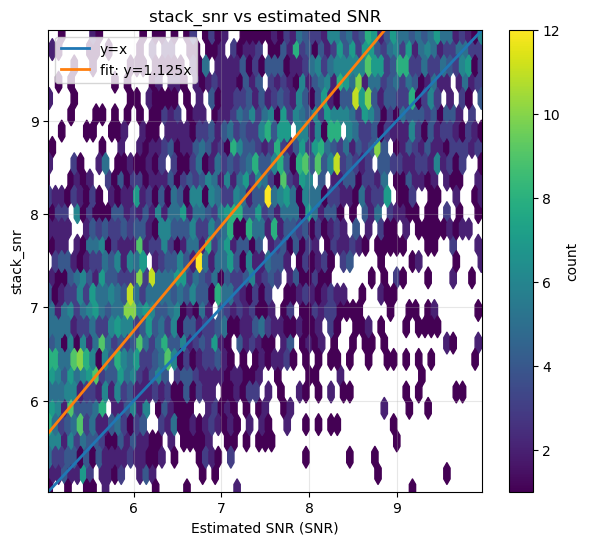

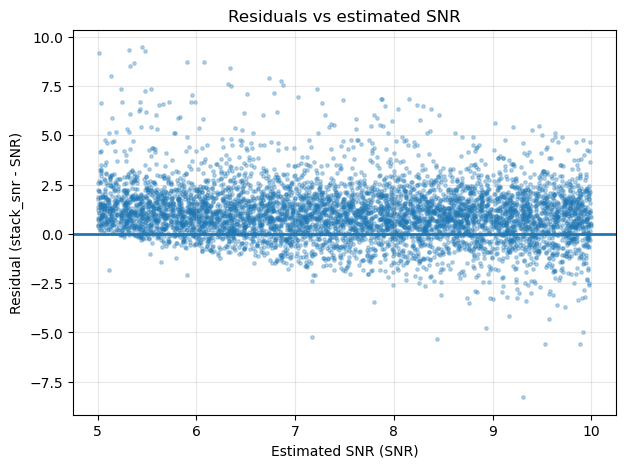

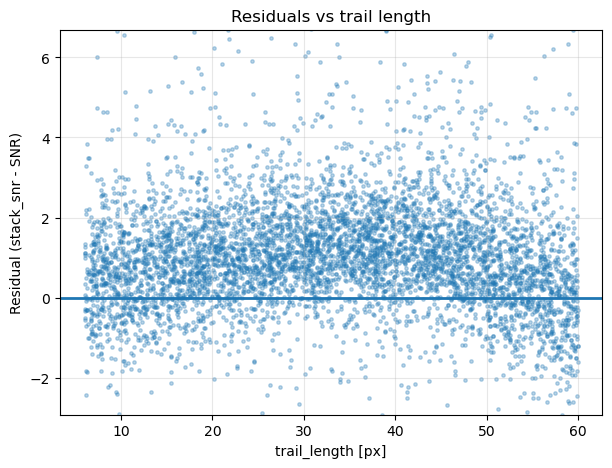

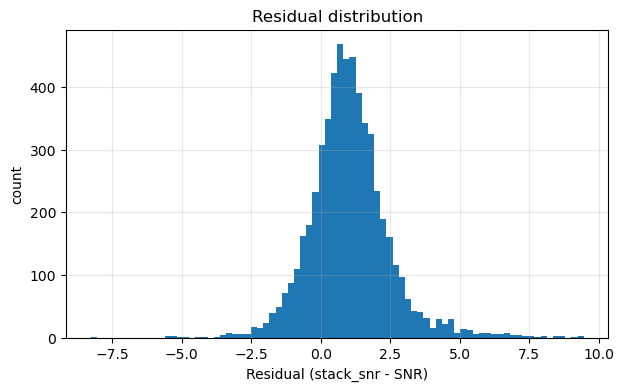

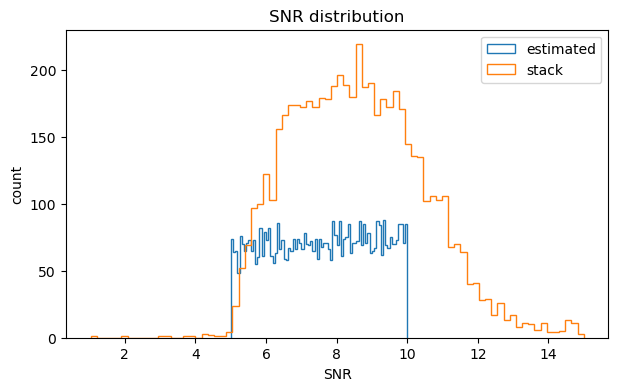

In [22]:
evaluate_snr_catalog (df_tk, save_path="/sdf/data/rubin/user/mrakovci/Projects/Asteroid_detection_CNN/plots")

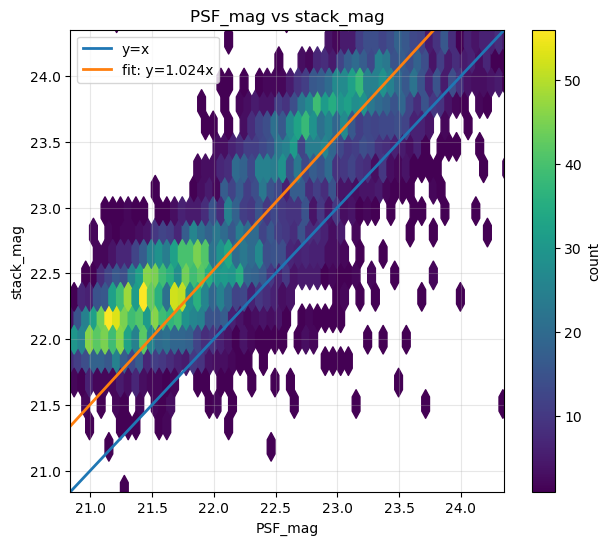

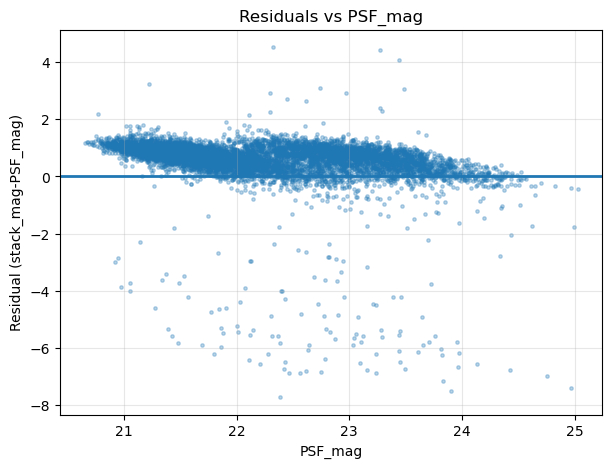

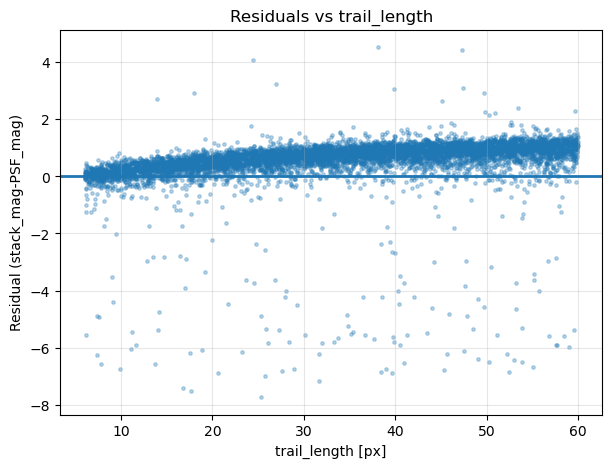

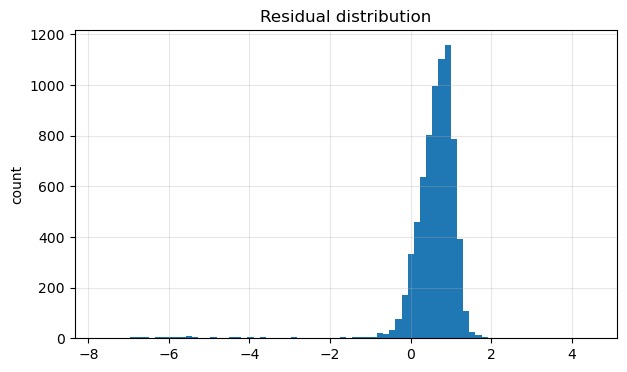

In [23]:
magnitude_eval (df_tk, save_path="/sdf/data/rubin/user/mrakovci/Projects/Asteroid_detection_CNN/plots")